We store the current best model in this notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, \
    precision_recall_curve, auc
from sklearn.preprocessing.label import LabelBinarizer
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase, Classifier, Regression, Stacked
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, PerElementOperator, CVOperator, df_cv_split
from utils import make_plots

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Split the training data into folds respecting the breakpoints.

In [3]:
breakpoint_df = pd.read_csv('data/cagi5_bkpt.csv')
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[1], [4], [3], [2], [0]],
 'release_GP1BB': [[0, 1], [2], [4], [3], [5]],
 'release_HBB': [[2], [0], [1], [], []],
 'release_HBG1': [[0], [1], [2], [3], []],
 'release_HNF4A': [[3], [2], [1], [0], []],
 'release_IRF4': [[6, 4], [2, 1], [7, 0], [3], [5]],
 'release_IRF6': [[0, 8], [5, 1], [4, 3], [7, 2], [6]],
 'release_LDLR': [[1], [3], [4], [0], [2]],
 'release_MSMB': [[0, 2], [3, 1], [5, 4], [7, 8], [6]],
 'release_MYCrs6983267': [[4, 3], [6, 2], [8, 1], [0, 5], [7]],
 'release_PKLR': [[1, 3], [7, 2], [6, 5], [0], [4]],
 'release_SORT1': [[0, 7], [6, 4], [3, 8], [1, 5], [2]],
 'release_TERT-GBM': [[3], [1], [4], [2], [0]],
 'release_TERT-HEK293T': [[1], [2], [4], [3], [0]],
 'release_ZFAND3': [[4, 7, 9], [2, 6], [3, 0], [10, 1], [8, 5]]}

## Create features

In [4]:
deepseadiffs = DeepSeaSNP(feattypes=['diff'])
dnase = DNase()
subst = SubstitutionOneHot()
enhancer1hot = EnhancerOneHot()
snpcontext2 = SNPContext(context_size=2)
snpcontext4 = SNPContext(context_size=4)
conservation = Conservation()
stacked = Stacked('deep-dnase-cons')

### Use tuned hyperparameters

These are taken from a kaggle kernel notebook

In [5]:
tuned_params={
    'max_depth': 2, #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': 0.6, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': 0.5, #[0.5,0.6,0.7,0.8],
    'n_estimators': 1000, #[1000,2000,3000]
    'reg_alpha': 0.03 #[0.01, 0.02, 0.03, 0.04]
}

These are tuned by Bayesian optimisation (in another notebook)

In [6]:
tuned_params = {
 'colsample_bytree': 0.7524052235178577,
 'learning_rate': 0.39783003619093765,
 'max_depth': 7,
 'min_child_weight': 4.0467095559059505,
 'reg_alpha': 0.030682622499703896,
 'reg_lambda': 0.40505823486422077,
 'subsample': 1.0
}

### Multiple features

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4
0.6943278872092431 0.4754820117293403


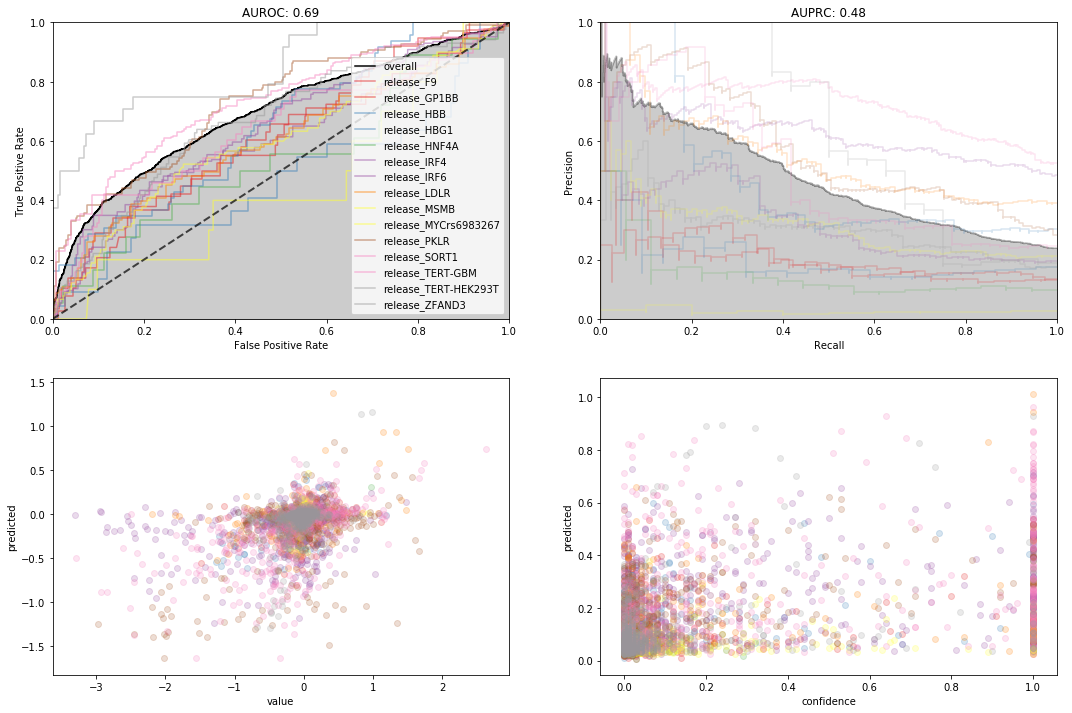

In [7]:
multi = MultiFeatures([deepseadiffs, dnase, conservation])
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Regression,
                       model_kwargs={
                           'features': multi,
                           'model_name': 'xgb',}),
                           # 'model_kwargs': tuned_params}),
                   fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()
(fpr, tpr, thresholds, auroc), (precision, recall, thresholds, auprc), _, _ = make_plots(cv_regress)
print(auroc, auprc)

In [24]:
import validate, importlib
importlib.reload(validate)
from validate import pr_one_against_many
from models import call_variants_from_regression
preds = call_variants_from_regression(cv_regress)
auprc_called_uncalled, auprc_positive_rest, auprc_negative_rest = pr_one_against_many(preds)
print(auprc_called_uncalled, auprc_positive_rest, auprc_negative_rest)

0.4754820117293403 0.18833202019348338 0.43575426374087844


### Save best

In [8]:
cv_regress.to_csv('data/best.csv')
_ = open('data/best-AUPRC.txt', mode='w').write('{}\n'.format(auprc))
_ = open('data/best-AUROC.txt', mode='w').write('{}\n'.format(auroc))